# 房价预测案例
## Step 1：检视源数据集

In [15]:
import numpy as np
import pandas as pd

### 读入数据
- 一般来说源数据的id字段没什么用，可以直接用作Pandas DataFrame的index

In [16]:
train_df = pd.read_csv('../input/train.csv',index_col=0)
test_df = pd.read_csv('../input/test.csv',index_col=0)

### 检视数据

In [17]:
train_df.head() # 查看前5行数据

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


这时候大概心里有数，哪些地方需要人为处理（比方说NaN值，离散值等），以做到源数据更好的被Process

## Step 2：合并数据

这么做主要是为了用DataFrame进行数据处理的时候更加方便，等所有预处理完了之后，再分开

首先，SalePrice作为训练目标，只会出现在训练集中，不会出现在测试集（要不然你测试什么？）。所以我们要先把SalePrice这一列拿出来，不让它碍事

先看一下SalePrice长什么样：

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb11ff037b8>,
      dtype=object)

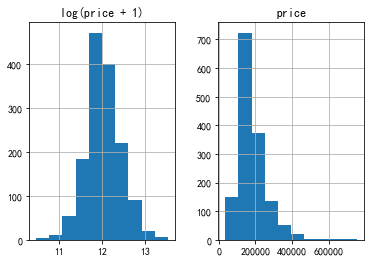

In [18]:
%matplotlib inline

prices = pd.DataFrame({
    'price':train_df['SalePrice'],
    'log(price + 1)':np.log1p(train_df['SalePrice'])
})

prices.hist()

可见，Label本身并不平滑，为了分类器的学习更加准确，我们首先要把Label“平滑化”（正态化）

这一步如果Miss掉，可能会导致最终结果达不到标准

如果这里把数据平滑化了，那么最后算结果的时候，要记得把预测的平滑数据给变回去

按照“怎么来怎么去”的原则，log1p()就需要expm1()；同理,log()就需要exp()...

log1p，也就是log(x + 1)，避免出现log(0)的问题



In [19]:
# pop出SalePrice这一列，并保存到y_train中
y_train = np.log1p(train_df.pop('SalePrice'))

然后把剩下的部分合并起来

In [20]:
all_df = pd.concat((train_df, test_df),axis = 0)

此时，all_df就是合并在一起的DataFrame

In [21]:
all_df.shape

(2919, 79)

## Step 3：变量转化

类似『特征工程』。就是把不方便处理或者不unify的数据给统一


### 正确化变量属性

首先，我们注意到，*MSSubClass* 的值是一个category

但是Pandas不懂，使用DataFrame时，这类数字符号会被默认记成数字

这就很有误导性，所以我们需要把它变回成*string*

In [22]:
all_df['MSSubClass'].dtype

dtype('int64')

In [23]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

变成str以后再做个统计

In [26]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

### 把category的变量转变成numerical表达形式

当我们用数字来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。因此我们可以用One-Hot的方法来表达category

pandas自带的get_dummies方法，可以做到一键One-Hot

In [33]:
pd.get_dummies(all_df['MSSubClass'],prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


此时MSSubClass就被分成了12个column，每一个代表一个category。是就是1，不是就是0

同理，我们要把所有的category数据都给One-Hot

In [39]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,Garage

### 处理好numerical变量

就算是numerical的变量，也还会有一些小问题

比如，有一些数据是缺失的（NaN）：

In [51]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(11)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
BsmtFinSF1        1
dtype: int64

可以看到，缺失最多的是LotFrontage

处理这些缺失的信息，得靠好好审题。一般来说，数据集的描述里会写的很清楚，这些缺失都代表着什么。当然，如果实在没有的话，也只能靠自己的『想当然』

在这里，我们『试着』用平均值来填满这些空缺

In [56]:
mean_col = all_dummy_df.mean()
mean_col.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [57]:
all_dummy_df = all_dummy_df.fillna(mean_col)

看看是不是没有空缺了

In [59]:
all_dummy_df.isnull().sum().sum()

0

### 标准化Numerical

这一步并不是必要，但是得看你想要用的分类器是什么。一般来说，regression的分类器都比较敏感，最好是把源数据给放在一个标准分布内。不要让数据间的差距太大

这里，我们不需要把One-Hot的那些0/1数据给标准化。我们的目标应该是那些本来就是numerical的数据：

先来看看 哪些是numerical的：

In [92]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

计算标准分布：(X-EX) / s

让我们的数据点更平滑，更便于计算

注意：我们这里也是可以继续使用Log的，只是展示一下多种“使数据平滑”的办法

In [93]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean() # 均值
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std() # 标准差
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## Step 4：建立模型

### 把数据集分回 训练/测试集

In [110]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [111]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

### Ridge Regreesion

用Ridge Regreesion模型跑一遍看看（对于多因子的数据集，这种模型可以方便的把所有的var无脑放进去）

In [112]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

这一步不是很重要，只是把DataFrame转化成Numpy Array，这样与Sklearn更相配

In [113]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values
type(X_train)

numpy.ndarray

用Sklearn自带的cross validation（交叉验证）方法来测试模型

In [114]:
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

存下所有的CV值，看看哪个alpha值更好（也就是『调参数』）

Text(0.5,1,'Alpha vs CV Error')

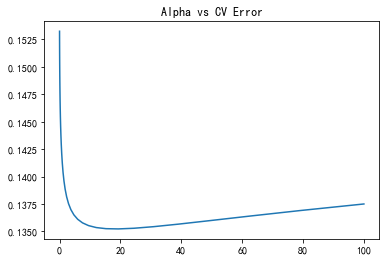

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas,test_scores)
plt.title('Alpha vs CV Error')

可见，大概alpha=10～20的时候，score可以达到0.135左右

### Random Forest

In [105]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Max Features vs CV Error')

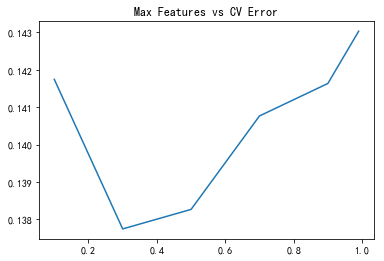

In [109]:
plt.plot(max_features, test_scores)
plt.title('Max Features vs CV Error')

## Step 5：Ensemble

这里我们用一个Stacking的思维来汲取两种或者多种模型的优点

首先，我们把最好的Parameter拿出来，做成最终的model

In [116]:
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500,max_features=.3)

In [117]:
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

上面提到，因为最前面我们给Label做了个log(1+x)，所以这里需要把predit的值给expm1回去

In [118]:
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

一个完整的Ensemble是把这群model的预测结果作为新的input，再做一次预测，这里我们用简单的方法，直接『平均化』

In [121]:
y_final = (y_ridge + y_rf) / 2 # 有点像投票的形式，每个人的票占一份

## Step 6：提交结果

In [122]:
submisson_df = pd.DataFrame(
    data = {
        'Id' : test_df.index,
        'SalePrice' : y_final
    })

In [123]:
submisson_df

,Id,SalePrice
0,1461,119073.437478
1,1462,150607.281372
2,1463,175096.100483
3,1464,189424.159413
4,1465,194735.250462
5,1466,176030.860446
6,1467,176914.831809
7,1468,169030.530192
8,1469,184201.275470
9,1470,123666.659033


至此，结束～